In [83]:
%%file main3.c

double correlacion_kendall(double *x, double *y, int n) {
    double concordantes = 0.0;
    double discordantes = 0.0;

    for (int i = 0; i < n - 1; i++) {
        for (int j = i + 1; j < n; j++) {
            // Contar pares concordantes y discordantes
            concordantes += (x[i] < x[j] && y[i] < y[j]) || (x[i] > x[j] && y[i] > y[j]);
            discordantes += (x[i] < x[j] && y[i] > y[j]) || (x[i] > x[j] && y[i] < y[j]);
        }
    }

    double tau = (concordantes - discordantes) / (0.5 * n * (n - 1));
    return tau;
}

Overwriting main3.c


In [84]:
! gcc -c main3.c -o main3.o
! gcc -shared main3.o -o main3.so

In [85]:
def correlacion_kendall(x, y, n):
    concordantes = 0.0
    discordantes = 0.0


    for i in range(n - 1):
        for j in range(i + 1, n):
            concordantes += (x[i] < x[j] and y[i] < y[j]) or (x[i] > x[j] and y[i] > y[j])
            discordantes += (x[i] < x[j] and y[i] > y[j]) or (x[i] > x[j] and y[i] < y[j])

    tau = (concordantes - discordantes) / (0.5 * n * (n - 1))
    return tau

In [86]:
import ctypes
import numpy as np

lib = ctypes.CDLL('./main3.so') 

lib.correlacion_kendall.argtypes = [np.ctypeslib.ndpointer(dtype=np.double),  
                                    np.ctypeslib.ndpointer(dtype=np.double),  
                                    ctypes.c_int
                                    ]
lib.correlacion_kendall.restype = ctypes.c_double

In [87]:
from scipy.stats import kendalltau


arreglo1 = np.random.rand(16)
arreglo2 = np.random.rand(16)

mean_x = np.mean(arreglo1)
mean_y = np.mean(arreglo2)

rpta_c = lib.correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
rpta_py = correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
rpta_scipy, _ = kendalltau(arreglo1, arreglo2)

print(f"Resultado de la función de C: {rpta_c}")
print(f"Resultado de la funcion de Python: {rpta_py}")
print(f"Resultado de spearmanr: {rpta_scipy}")

Resultado de la función de C: 0.18333333333333332
Resultado de la funcion de Python: 0.18333333333333332
Resultado de spearmanr: 0.18333333333333335


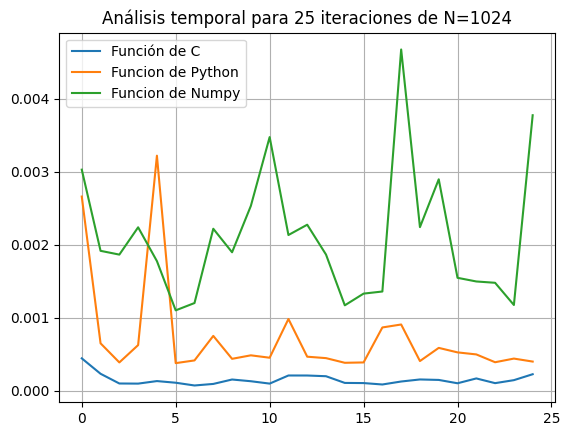

In [88]:
import time 
import matplotlib.pyplot as plt

N = 1024
iter = 25

c_time= []
py_time = []
numpy_time = []


for i in range(iter):

    c_start_time = time.time()
    rpta_c = lib.correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
    c_end_time = time.time()
    c_time.append(c_end_time - c_start_time) 

    py_start_time = time.time()
    rpta_py = correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
    py_end_time = time.time()
    py_time.append(py_end_time - py_start_time) 

    numpy_start_time = time.time()
    rpta_scipy, _ = kendalltau(arreglo1, arreglo2)
    numpy_end_time = time.time()
    numpy_time.append(numpy_end_time - numpy_start_time) 



plt.plot(range(iter),c_time, label='Función de C')
plt.plot(range(iter),py_time, label='Funcion de Python')
plt.plot(range(iter),numpy_time, label='Funcion de Numpy')
plt.legend()
plt.grid(True)
plt.title('Análisis temporal para 25 iteraciones de N=1024')
plt.show()

In [89]:
size = [2**i for i in range(10, 17)]
iter= 25
big_c_times = []
big_py_times= []

for N in size:
    c_times = []
    py_times = []

    for _ in range(iter):

        arreglo1 = np.random.rand(N)
        arreglo2 = np.random.rand(N)
        
        mean_x = np.mean(arreglo1)
        mean_y = np.mean(arreglo2)

        c_start_time = time.time()
        rpta_c = lib.correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
        c_end_time = time.time()
        c_times.append(c_end_time - c_start_time)

        py_start_time = time.time()
        rpta_py = correlacion_kendall(arreglo1, arreglo2, len(arreglo1))
        py_end_time = time.time()
        py_times.append(py_end_time - py_start_time)

    # Calcular la mediana de los tiempos
    big_c_times.append(np.median(c_times))
    big_py_times.append(np.median(py_times))

# Calcular el SpeedUp
speedup = [big_c_times /big_py_times for big_py_times,big_c_times in zip(big_py_times, big_c_times)]
#speedup = np.divide(big_py_times, big_c_times)
# Graficar speedup
plt.plot(size, speedup)
plt.xscale('log', base=2)
plt.xlabel('Tamaño de N')
plt.ylabel('SpeedUp (vs Python)')
plt.title('SpeedUp para diferentes tamaños de N')
plt.show()